# Introduction

This is the inference notebook for drawing bounding boxes on satellite images.

From the top panel, just hit "Runtime > Run all"

Github repo: https://github.com/yasserius/satellite_image_tinhouse_detector

# Install the environment

Python 3.6 and Tensorflow 2.3 should work for this to work.

In [1]:
!python --version

Python 3.7.10


In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


## Setting directory locations

In [3]:
MODELS_DIR = "/content/models"
OBJ_DET_DIR = "/content/models/research/object_detection"

## Cloning from github

Following the [official guide](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md) to install.

In [4]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 1983, done.
remote: Counting objects: 100% (1983/1983), done.
remote: Compressing objects: 100% (916/916), done.
remote: Total 55952 (delta 1243), reused 1665 (delta 1049), pack-reused 53969
Receiving objects: 100% (55952/55952), 572.56 MiB | 38.48 MiB/s, done.
Resolving deltas: 100% (38312/38312), done.


In [6]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1643750 sha256=0d1ee2b1f11ce94a98a1d6b985758c9740a089107fb9b076ee28765d4abd70f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-1241mvcu/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


## Adding to path to environment variables

In [7]:
import os

main_dir = "/content"
os.environ['PYTHONPATH'] += f':{main_dir}:{main_dir}/slim'
os.environ['PYTHONPATH'] += f':{main_dir}:{main_dir}/models'
os.environ['PYTHONPATH'] += f':{main_dir}:{main_dir}/models/research'

## Testing the installation

In [8]:
!python "$OBJ_DET_DIR/builders/model_builder_tf2_test.py"

2021-04-13 23:16:06.229508: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-04-13 23:16:09.097682: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-13 23:16:09.098701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-13 23:16:09.171232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 23:16:09.171841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB devi

There will be a really long output.

But if the installation succeeded, you should see something like this at the bottom:

```
----------------------------------------------------------------------
Ran 20 tests in 45.495s

OK (skipped=1)
```

# Load the model

## Download model

The pretrained model (tensorflow checkpoint) is stored in this [Drive link](https://drive.google.com/uc?id=1QldfEaYxRvu2uxwhepAFmmFTgWn8_SCf&export=download).

In [9]:
!pip install gdown

In [12]:
import gdown
from zipfile import ZipFile

url = "https://drive.google.com/uc?id=1QldfEaYxRvu2uxwhepAFmmFTgWn8_SCf"
output_file = "model.zip"

gdown.download(url=url, output=output_file, quiet=True)

with ZipFile(output_file, 'r') as zipObj:
   zipObj.extractall()

## Load model

In [14]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = "/content/export/pipeline.config"
PATH_TO_CKPT = "/content/export/checkpoint"

print('Loading model... ', end='')

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

Loading model... 

## Download the label map file

In [15]:
# Downlaod label map
!wget "https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/label_map.pbtxt"

--2021-04-13 23:22:34--  https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/label_map.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36 [text/plain]
Saving to: ‘label_map.pbtxt’

label_map.pbtxt     100%[===================>]      36  --.-KB/s    in 0s      

2021-04-13 23:22:34 (2.17 MB/s) - ‘label_map.pbtxt’ saved [36/36]



In [16]:
category_index = label_map_util.create_category_index_from_labelmap("/content/label_map.pbtxt",
                                                                    use_display_name=True)

print(category_index)

{1: {'id': 1, 'name': 'house'}}


## Download test images

In [17]:
%%bash
wget "https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/images/test/1.png"
wget "https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/images/test/2.png"
wget "https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/images/test/3.png"

--2021-04-13 23:22:47--  https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/images/test/1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318489 (311K) [image/png]
Saving to: ‘1.png’

     0K .......... .......... .......... .......... .......... 16% 52.1M 0s
    50K .......... .......... .......... .......... .......... 32% 47.7M 0s
   100K .......... .......... .......... .......... .......... 48% 97.7M 0s
   150K .......... .......... .......... .......... .......... 64% 59.0M 0s
   200K .......... .......... .......... .......... .......... 80% 83.5M 0s
   250K .......... .......... .......... .......... .......... 96% 88.4M 0s
   300K .......... .                                          100%  171M=0.004s

2021-04-13 

# Run inference

In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

If you want to test this on satellite images of your own, upload them to colab from the left panel and run the cells below.

Tip: make sure the images are square-ish and at least 500 by 500 in size.

In [58]:
TEST_IMAGES = glob.glob("/content/CHCH_4chanel.png")

In [61]:
TEST_IMAGES = glob.glob("/content/CHCH_snip.png")

In [63]:
TEST_IMAGES = glob.glob("/content/1.png")

got to a
derp


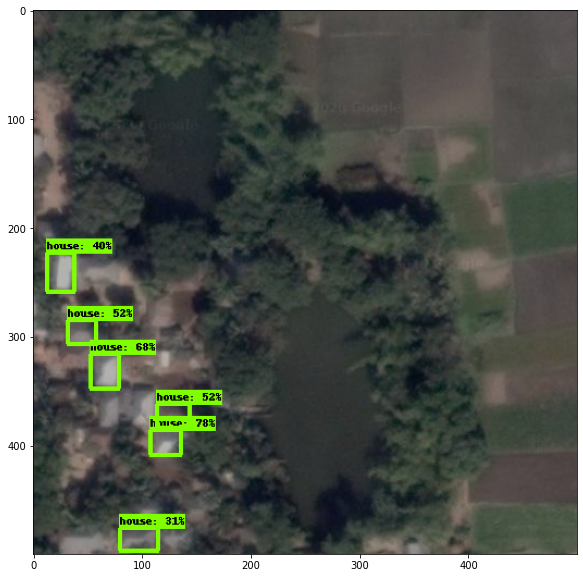

In [64]:
import glob
print('got to a')

for image_path in TEST_IMAGES:
  print("derp")
  image_np = load_image_into_numpy_array(image_path)

  if image_np.shape[2] == 4:
    image_np = image_np[:, :, 0:3] # png has 4th channel

  input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

  image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(image, shapes)
  detections = detection_model.postprocess(prediction_dict, shapes)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
  detections['num_detections'] = num_detections

  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes']+label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=.30,
    agnostic_mode=False)
  
  plt.figure(figsize=(10,10))
  plt.imshow(image_np_with_detections)

plt.show()